<a href="https://colab.research.google.com/github/Zshoham/YHB/blob/main/assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this assignment, we explore the problem presented [here](https://www.kaggle.com/c/home-depot-product-search-relevance/data). The dataset contains data from Home Depot searches. The data that we are interested in is the search query itself, the product description, and the similarity between them. Our goal is to create a model that, given a text query and product description, can predict their similarity.
We use two general model types:

* Character Level Models - Here, we explore models that use a character level tokenizer, meaning that the text features are the unique characters. We start with a Siamese Neural Network. We later create a few classical ML models, and finally, we use the neural network as a feature extractor, feeding the features into classical ML models.

* Word Level Models - Here, we explore models that use a word-level tokenizer, meaning that the text features are the text's unique words. We use similar models to what we used in the character level section with slight modifications where needed

> the notebook contains two main sections, the character level and word level models, each section contains subsections for each of the clauses specefied in the assignment, and each subsctions often contains subsubsections for each of the models we build. At the end of each models evaluation we present a graph with the performance metrics. 

> Note that the notebook is much nicer to read in google colab as it offers markdown folding for the sections to make the notebook more organized.

# Data Loading

In [ ]:
!pip install py7zr

In [ ]:
import os
import time
import requests
import py7zr

if not os.path.isdir("data"):
  data = requests.get("https://drive.google.com/uc?export=download&id=1_oG5wpPpfLFloe0Qzgfg-jlomzMGJ8aK")
  with open("data.7z", 'wb') as f:
    f.write(data.content) 

  with py7zr.SevenZipFile('data.7z', mode='r') as z:
    z.extractall()

In [ ]:
import pandas as pd

train = pd.read_csv("home-depot-product-search-relevance/train.csv", encoding='latin-1')
test = pd.read_csv("home-depot-product-search-relevance/test.csv", encoding='latin-1')
desc = pd.read_csv("home-depot-product-search-relevance/product_descriptions.csv", encoding='latin-1')
solution = pd.read_csv("home-depot-product-search-relevance/solution.csv", encoding='latin-1')

train_df = pd.merge(train, desc, on='product_uid')
train_df = train_df.sample(frac=1)
train_df = train_df.iloc[:int(len(train_df)*0.8)]

val_df = train_df.iloc[int(len(train_df)*0.8):]

test_df = pd.merge(test, desc, on='product_uid')
test_df = test_df[solution["Usage"]!='Ignored']
test_df.insert(4, 'relevance',  solution.relevance)

# Processing

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence

def process_data(dataframe, tokenizer, max_search_len, max_description_len):
  search = tokenizer.texts_to_sequences(dataframe['search_term'])
  description = tokenizer.texts_to_sequences(dataframe['product_description'])

  search = sequence.pad_sequences(search, maxlen=max_search_len, padding='post')
  description = sequence.pad_sequences(description, maxlen=max_description_len, padding='post')

  labels = dataframe['relevance'].to_numpy()

  return {
      "search": search,
      "description": description,
      "labels": labels
  }

# Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import math

comparison = pd.DataFrame(columns=["Model type", "runtime",
                                   "Train RMSE", "Val RMSE", "Test RMSE",
                                   "Train MAE", "Val MAE", "Test MAE"])
def add_to_table(model_name, runtime, 
                 train_rmse, val_rmse, test_rmse,
                 train_mae, val_mae, test_mae):
  comparison.loc[len(comparison)] = [model_name, runtime, 
                                     train_rmse, val_rmse, test_rmse,
                                     train_mae, val_mae, test_mae]


def show_keras_metrics(hist, model_name):
  fig, axes = plt.subplots(1,2, figsize=(15,10), facecolor=(1, 1, 1))
  fig.suptitle(model_name, fontsize=16)
  # fig.tight_layout()

  axes[0].plot(hist.history['mae'], 'r', hist.history['val_mae'], 'b')
  axes[0].set_xlabel('Epochs', fontsize=12)
  axes[0].set_ylabel('mae', fontsize=12)
  axes[0].set_title('mae for epoch', fontsize=14)
  axes[0].legend(['mae','val_mae'], fontsize=14)

  axes[1].plot(hist.history['root_mean_squared_error'], 'r', 
                  hist.history['val_root_mean_squared_error'], 'b')
  axes[1].set_xlabel('Epochs', fontsize=12)
  axes[1].set_ylabel('rmse', fontsize=12)
  axes[1].set_title('rmse for epoch', fontsize=14)
  axes[1].legend(['rmse','val_rmse'], fontsize=14)


def evaluate_keras_model(model_name, history, runtime, test_scores):
  best_ephoch = history.history['val_root_mean_squared_error'].index(
      min(history.history['val_root_mean_squared_error']))
  
  train_rmse = history.history['root_mean_squared_error'][best_ephoch]
  train_mae = history.history['mae'][best_ephoch]
  val_rmse = history.history['val_root_mean_squared_error'][best_ephoch]
  val_mae = history.history['val_mae'][best_ephoch]
  test_rmse = test_scores[1]
  test_mae = test_scores[2]

  add_to_table(model_name, runtime, train_rmse, val_rmse, 
               test_rmse, train_mae, val_mae, test_mae)
  
  show_keras_metrics(history, f"{model_name}\n learning time: {round(runtime)} seconds\n test_rmse={round(test_rmse, 5)}\n test_mae={round(test_mae, 5)}")


def evaluate_sklearn_model(model_name, model, train, val, test, runtime):
  print(f"model {model_name} took {runtime} seconds to learn")

  print("evaluating train set...")
  train_pred = model.predict(train[0])
  train_rmse = sqrt(mean_squared_error(train[1], train_pred))
  train_mae = mean_absolute_error(train[1], train_pred)
  print(f"train rmse={train_rmse}  train mae={train_mae}")

  print("evaluating validation set...")
  val_pred = model.predict(val[0])
  val_rmse = sqrt(mean_squared_error(val[1], val_pred))
  val_mae = mean_absolute_error(val[1], val_pred)
  print(f"validation rmse={val_rmse}  validation mae={val_mae}")

  print("evaluating test set...")
  test_pred = model.predict(test[0])
  test_rmse = sqrt(mean_squared_error(test[1], test_pred))
  test_mae = mean_absolute_error(test[1], test_pred)
  print(f"test rmse={test_rmse}  test mae={test_mae}")

  add_to_table(model_name, runtime, train_rmse, val_rmse, 
               test_rmse, train_mae, val_mae, test_mae)

# Exploration

In this secion we can see some stats on the data as well as examples of both tokenaization methods including the dictioraies we created.

In [ ]:
train_df.head()

,id,product_uid,product_title,search_term,relevance,product_description
1895,5841,101013,DecraMold DM 1067EM 5/16 in. x 3/4 in. Solid P...,molding trim pliers,2.33,Use DecraMold 5/16 x 3/4 in. x 96 in. Embossed...
68207,204723,192715,Swan Dual Mount Granite 33x22x9 in. 0-Hole Eve...,swan espresso dual mount granite sink,3.00,"Made from 80% natural quartz stone, this 33 in..."
947,2975,100525,Toro TimeCutter SS4225 42 in. 22 HP Kohler Zer...,ridding mowers,2.67,The Toro TimeCutter SS4225 is a hydrostatic ze...
5278,16510,102917,American Standard Champion 4 Max Right Height ...,americian standard champion 4 toliets,2.67,"Meet the Champion 4 Max Elongated toilet, the ..."
9582,29688,106387,"GREE High Efficiency 18,000 BTU (1.5Ton) Ductl...",air conditioner split,3.00,The RIO High Efficiency Ductless Mini-Split He...


In [ ]:
val_df.head()

,id,product_uid,product_title,search_term,relevance,product_description
17226,53195,113790,Storability 33 in. L x 31.5 in. H Wall Mount S...,garage shelving units,2.67,Storability modular wall storage is the ideal ...
45728,138930,150030,EarthMinded Brass Spigot and Drain Upgrade Kit,rain barrel kit,2.33,We tested dozens of spigots and bibcocks for o...
64073,193005,183696,Foremost Naples 61 in. W x 22 in. D Double Sin...,stone effect sante cecilia top,2.33,The Naples 61 in. vanity completes with Stone ...
32451,99205,131099,Home Decorators Collection Parsons Writing Des...,white desks,3.00,Add sleek sophistication to your office with t...
1065,3341,100590,Home Decorators Collection Rosengrant 59.5 in....,fireplace tv stands,3.00,This attractive media Fireplace mantel was des...


In [ ]:
test_df.head()

,id,product_uid,product_title,search_term,relevance,product_description
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,2.33,"Not only do angles make joints stronger, they ..."
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,2.33,"Not only do angles make joints stronger, they ..."
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,2.67,"Not only do angles make joints stronger, they ..."
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,2.00,"Not only do angles make joints stronger, they ..."
6,10,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,bath and shower kit,2.67,Classic architecture meets contemporary design...


In [ ]:
train_df['relevance'].describe()

count    59253.000000
mean         2.382435
std          0.533941
min          1.000000
25%          2.000000
50%          2.330000
75%          3.000000
max          3.000000
Name: relevance, dtype: float64

In [ ]:
train_df['relevance'].unique()

array([2.33, 3.  , 2.67, 1.67, 2.  , 1.33, 1.  , 2.5 , 1.5 , 1.25, 2.75,
       2.25, 1.75])

In [ ]:
test_df['relevance'].unique()

array([2.33, 2.67, 2.  , 3.  , 1.  , 1.67, 1.33, 1.75, 2.75, 2.5 , 2.25,
       1.5 , 1.25])

In [ ]:
train_search = train_df['search_term'].to_numpy()
train_desc = train_df['product_description'].to_numpy()

def print_length_stats(tokenizer):
  searches = tokenizer.texts_to_sequences(train_df['search_term'])
  descriptions = tokenizer.texts_to_sequences(train_df['product_description'])
  search_lengths = np.array([len(arr) for arr in searches])
  description_lengths = np.array([len(arr) for arr in descriptions])

  print(" query stats:")
  print(f"  min query length: {search_lengths.min()}")
  print(f"  max query length: {search_lengths.max()}")
  print(f"  average query length: {search_lengths.mean()}")
  print(f"  std for query length: {search_lengths.std()}")
  print()
  print(" description stats:")
  print(f"  min query length: {description_lengths.min()}")
  print(f"  max query length: {description_lengths.max()}")
  print(f"  average query length: {description_lengths.mean()}")
  print(f"  std for query length: {description_lengths.std()}")

In [ ]:
char_tokenizer = text.Tokenizer(char_level=True)
char_tokenizer.fit_on_texts(np.concatenate([train_search, train_desc]))

print("Character Level Stats")
print_length_stats(char_tokenizer)
print("\ndictionary: ")
char_tokenizer.word_index

Character Level Stats
 query stats:
  min query length: 2
  max query length: 60
  average query length: 19.002936560174167
  std for query length: 7.785859334290844

 description stats:
  min query length: 160
  max query length: 5510
  average query length: 886.8751961925979
  std for query length: 499.8830709997073

dictionary: 


{' ': 1,
 '!': 54,
 '"': 49,
 '#': 50,
 '$': 52,
 '%': 48,
 '&': 47,
 "'": 44,
 '(': 42,
 ')': 41,
 '*': 57,
 '+': 51,
 ',': 24,
 '-': 26,
 '.': 22,
 '/': 35,
 '0': 28,
 '1': 27,
 '2': 30,
 '3': 32,
 '4': 33,
 '5': 31,
 '6': 36,
 '7': 43,
 '8': 38,
 '9': 45,
 ':': 39,
 ';': 46,
 '<': 58,
 '=': 56,
 '>': 62,
 '?': 53,
 '@': 59,
 '[': 61,
 '\\': 63,
 ']': 60,
 '^': 67,
 '_': 55,
 '`': 66,
 'a': 4,
 'b': 21,
 'c': 12,
 'd': 11,
 'e': 2,
 'f': 17,
 'g': 18,
 'h': 13,
 'i': 5,
 'j': 40,
 'k': 25,
 'l': 10,
 'm': 16,
 'n': 7,
 'o': 6,
 'p': 15,
 'q': 34,
 'r': 8,
 's': 9,
 't': 3,
 'u': 14,
 'v': 23,
 'w': 20,
 'x': 29,
 'y': 19,
 'z': 37,
 '{': 64,
 '}': 65,
 '~': 68}

In [ ]:
word_tokenizer = text.Tokenizer(char_level=False)
word_tokenizer.fit_on_texts(np.concatenate([train_search, train_desc]))

print("Word Level Stats")
print_length_stats(word_tokenizer)
print("\ndictionary: ")
word_tokenizer.word_index

Word Level Stats
 query stats:
  min query length: 1
  max query length: 17
  average query length: 3.2375913455858774
  std for query length: 1.3429847620502693

 description stats:
  min query length: 24
  max query length: 1045
  average query length: 141.7301571228461
  std for query length: 80.8742542779617

dictionary: 


{'and': 1,
 'the': 2,
 'to': 3,
 'in': 4,
 'for': 5,
 'a': 6,
 'with': 7,
 'of': 8,
 'is': 9,
 'or': 10,
 'your': 11,
 '1': 12,
 'this': 13,
 'on': 14,
 '2': 15,
 'are': 16,
 'you': 17,
 'x': 18,
 'easy': 19,
 'from': 20,
 'that': 21,
 'use': 22,
 '3': 23,
 '4': 24,
 'it': 25,
 'be': 26,
 'up': 27,
 'an': 28,
 'can': 29,
 'water': 30,
 'ft': 31,
 'as': 32,
 'light': 33,
 'door': 34,
 'by': 35,
 'design': 36,
 '5': 37,
 'installation': 38,
 'steel': 39,
 'finish': 40,
 '8': 41,
 'home': 42,
 'not': 43,
 'provides': 44,
 'all': 45,
 'any': 46,
 'features': 47,
 'has': 48,
 'wood': 49,
 'high': 50,
 'will': 51,
 'wall': 52,
 'resistant': 53,
 'used': 54,
 'at': 55,
 'designed': 56,
 'included': 57,
 'see': 58,
 'more': 59,
 'white': 60,
 'no': 61,
 '6': 62,
 'system': 63,
 'energy': 64,
 'air': 65,
 'construction': 66,
 'outdoor': 67,
 'protection': 68,
 '65': 69,
 'california': 70,
 'provide': 71,
 'clean': 72,
 'when': 73,
 'glass': 74,
 'residents': 75,
 'year': 76,
 'proposition': 77,

# Siamese network building

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
search_input (InputLayer)       [(None, 60)]         0                                            
__________________________________________________________________________________________________
description_input (InputLayer)  [(None, 2500)]       0                                            
__________________________________________________________________________________________________
reshape_search (Lambda)         (None, 60, 1)        0           search_input[0][0]               
__________________________________________________________________________________________________
reshape_description (Lambda)    (None, 2500, 1)      0           description_input[0][0]          
______________________________________________________________________________________________

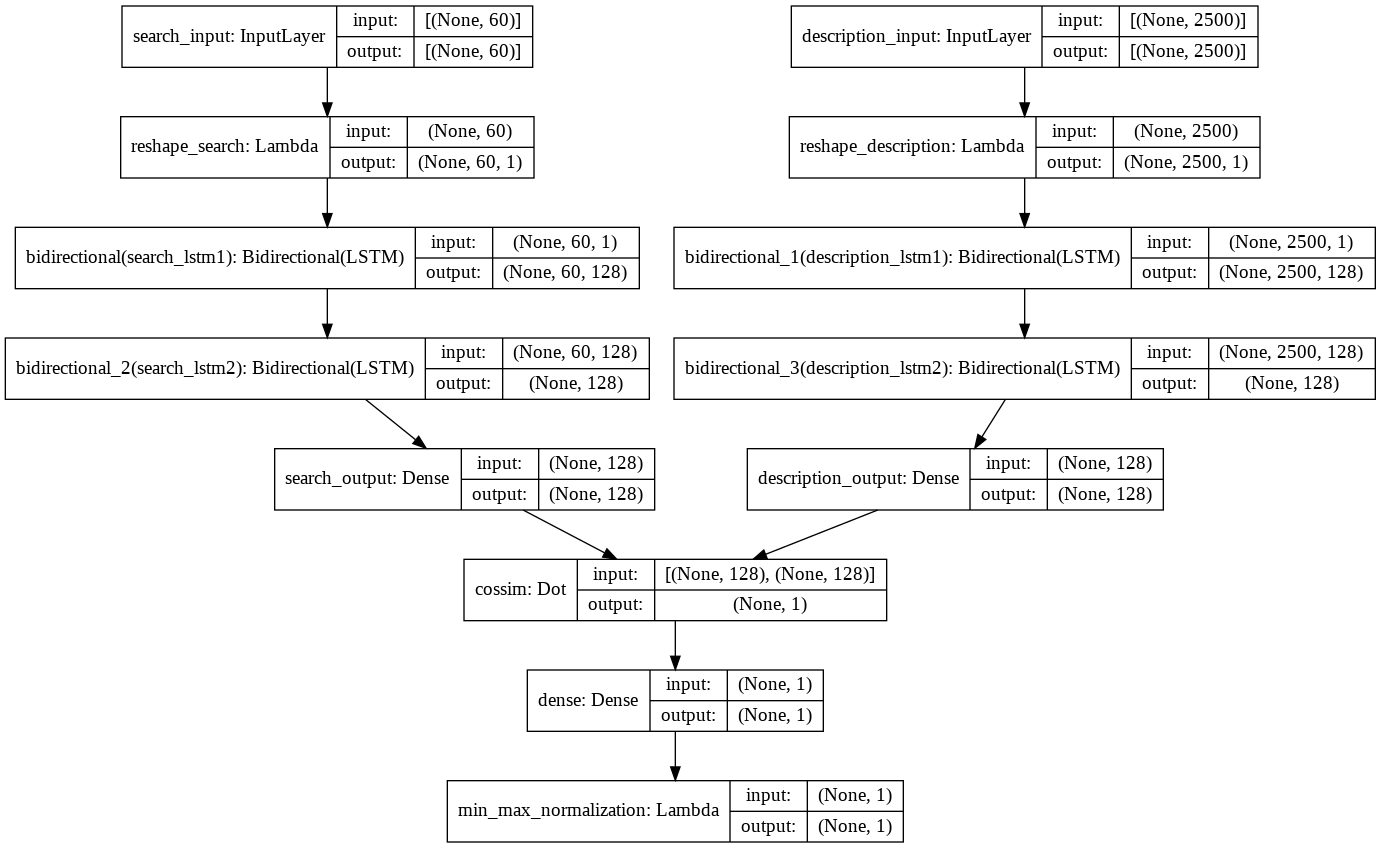

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from keras import metrics

def siamese_lstm(query_shape, desc_shape,
                 query_index_size, desc_index_size,
                 query_emb_size, desc_emb_size,
                 use_embedding=False, lstm_blocks=1):
  
  search_inp = layers.Input(query_shape, name="search_input")
  description_inp = layers.Input(desc_shape, name="description_input")

  if use_embedding:
      search_lstm = layers.Embedding(query_index_size, query_emb_size, embeddings_regularizer=regularizers.l2(1e-6), name=f"search_embedding")(search_inp)
      description_lstm = layers.Embedding(desc_index_size, desc_emb_size, embeddings_regularizer=regularizers.l2(1e-6), name=f"description_embedding")(description_inp)
  else:
    search_lstm = layers.Lambda(lambda tensor: tensor[...,np.newaxis],name=f"reshape_search")(search_inp)
    description_lstm = layers.Lambda(lambda tensor: tensor[...,np.newaxis],name=f"reshape_description")(description_inp)
  
  for i in range(1, lstm_blocks):
    search_lstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True, name=f"search_lstm{i}"))(search_lstm)
    description_lstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True, name=f"description_lstm{i}"))(description_lstm)
  search_lstm = layers.Bidirectional(layers.LSTM(64, name=f"search_lstm{lstm_blocks}"))(search_lstm)
  description_lstm = layers.Bidirectional(layers.LSTM(64, name=f"description_lstm{lstm_blocks}"))(description_lstm)      

  search_out = layers.Dense(128, activation='relu', name="search_output")(search_lstm)
  description_out = layers.Dense(128, activation='relu', name="description_output")(description_lstm)

  dot = layers.dot([search_out, description_out], axes=1, normalize=True, name="cossim")  # to calculate cosim
  
  out = layers.Dense(1, activation='sigmoid')(dot) # get all values to 0-1
  out = layers.Lambda(function=(lambda x: 2*x + 1), name="min_max_normalization")(out)  # min max normalization all values to 1-3

  model = keras.Model(inputs=[search_inp, description_inp], outputs=out)
  model.compile(optimizer='adam', loss='mse', metrics=[metrics.RootMeanSquaredError(), 'mae'])
  return model

CHAR_MAX_QUERY = 60   # out of 60
CHAR_MAX_DESC = 2500  # out of 5516

model = siamese_lstm((CHAR_MAX_QUERY), (CHAR_MAX_DESC),
                     len(char_tokenizer.word_index)+1,
                     len(char_tokenizer.word_index)+1,
                     10, 10, False, 2)

print(model.summary())
keras.utils.plot_model(model, show_shapes=True)

# 1. Character Level

## Preprocessing - 1.a

In [ ]:
CHAR_MAX_QUERY = 30   # out of 60
CHAR_MAX_DESC = 1500  # out of 5516


train_search = train_df['search_term'].to_numpy()
train_desc = train_df['product_description'].to_numpy()

val_search = val_df['search_term'].to_numpy()
val_desc = val_df['product_description'].to_numpy()

test_search = test_df['search_term'].to_numpy()
test_desc = test_df['product_description'].to_numpy()

char_tokenizer = text.Tokenizer(char_level=True)
char_tokenizer.fit_on_texts(np.concatenate([train_search, train_desc]))

train = process_data(train_df, char_tokenizer, CHAR_MAX_QUERY, CHAR_MAX_DESC)
val = process_data(val_df, char_tokenizer, CHAR_MAX_QUERY, CHAR_MAX_DESC)
test = process_data(test_df, char_tokenizer, CHAR_MAX_QUERY, CHAR_MAX_DESC)

## Siamese LSTM - 1.b

### Embedding + one LSTM layer

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

callbacks = [EarlyStopping(monitor='val_root_mean_squared_error', mode="min",
                           patience=3, restore_best_weights=True, verbose=1),
             ModelCheckpoint('models/char/embedding_1.h5',
                             monitor='val_root_mean_squared_error', mode="min",
                             verbose=1, save_best_only=True)]

model = siamese_lstm((CHAR_MAX_QUERY), (CHAR_MAX_DESC),
                     len(char_tokenizer.word_index)+1,
                     len(char_tokenizer.word_index)+1,
                     10, 10, True, 1)

start_learning_time = time.time()
history = model.fit(x=(train['search'], train['description']), y=train['labels'],
                    validation_data=((val['search'], val['description']), val['labels']),
                    batch_size=256, epochs=20, callbacks=callbacks,)
learning_time = time.time() - start_learning_time
learning_time

Epoch 1/20
232/232 [==============================] - 50s 168ms/step - loss: 0.3893 - root_mean_squared_error: 0.6238 - mae: 0.5308 - val_loss: 0.3234 - val_root_mean_squared_error: 0.5687 - val_mae: 0.4862

Epoch 00001: val_root_mean_squared_error improved from inf to 0.56871, saving model to models/char/embedding_1.h5
Epoch 2/20
232/232 [==============================] - 38s 164ms/step - loss: 0.3075 - root_mean_squared_error: 0.5545 - mae: 0.4692 - val_loss: 0.2957 - val_root_mean_squared_error: 0.5438 - val_mae: 0.4472

Epoch 00002: val_root_mean_squared_error improved from 0.56871 to 0.54376, saving model to models/char/embedding_1.h5
Epoch 3/20
232/232 [==============================] - 39s 168ms/step - loss: 0.2861 - root_mean_squared_error: 0.5349 - mae: 0.4359 - val_loss: 0.2908 - val_root_mean_squared_error: 0.5393 - val_mae: 0.4396

Epoch 00003: val_root_mean_squared_error improved from 0.54376 to 0.53925, saving model to models/char/embedding_1.h5
Epoch 4/20
232/232 [======

797.0128302574158

In [ ]:
test_scores = model.evaluate(x=(test['search'], test['description']), y=test['labels'], batch_size=512)
test_scores

219/219 [==============================] - 20s 92ms/step - loss: 0.2790 - root_mean_squared_error: 0.5282 - mae: 0.4345


[0.2790249288082123, 0.5282014012336731, 0.43446749448776245]

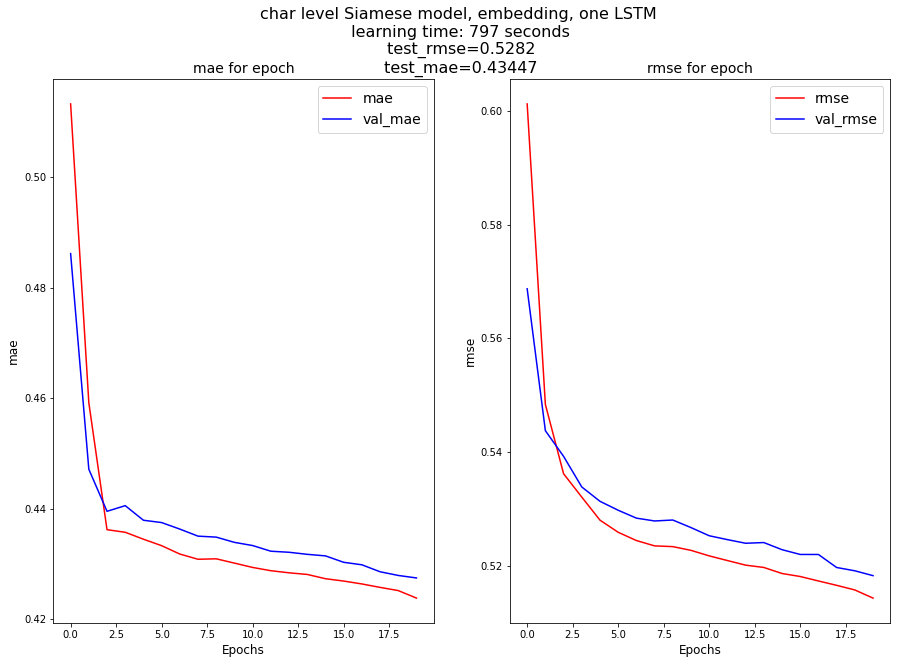

In [ ]:
evaluate_keras_model("char level Siamese model, embedding, one LSTM", history, learning_time, test_scores)

### Embedding + two LSTM layer

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

callbacks = [EarlyStopping(monitor='val_root_mean_squared_error', mode="min",
                           patience=3, restore_best_weights=True, verbose=1),
             ModelCheckpoint('models/char/embedding_2.h5',
                             monitor='val_root_mean_squared_error', mode="min",
                             verbose=1, save_best_only=True)]

model = siamese_lstm((CHAR_MAX_QUERY), (CHAR_MAX_DESC),
                     len(char_tokenizer.word_index)+1,
                     len(char_tokenizer.word_index)+1,
                     10, 10, True, 2)

start_learning_time = time.time()
history = model.fit(x=(train['search'], train['description']), y=train['labels'],
                    validation_data=((val['search'], val['description']), val['labels']),
                    batch_size=256, epochs=20, callbacks=callbacks,)
learning_time = time.time() - start_learning_time
learning_time

Epoch 1/20
232/232 [==============================] - 99s 392ms/step - loss: 0.4179 - root_mean_squared_error: 0.6461 - mae: 0.5481 - val_loss: 0.3677 - val_root_mean_squared_error: 0.6064 - val_mae: 0.5212

Epoch 00001: val_root_mean_squared_error improved from inf to 0.60636, saving model to models/char/embedding_2.h5
Epoch 2/20
232/232 [==============================] - 89s 383ms/step - loss: 0.3471 - root_mean_squared_error: 0.5891 - mae: 0.5049 - val_loss: 0.3270 - val_root_mean_squared_error: 0.5719 - val_mae: 0.4897

Epoch 00002: val_root_mean_squared_error improved from 0.60636 to 0.57188, saving model to models/char/embedding_2.h5
Epoch 3/20
232/232 [==============================] - 89s 382ms/step - loss: 0.3163 - root_mean_squared_error: 0.5624 - mae: 0.4794 - val_loss: 0.3062 - val_root_mean_squared_error: 0.5533 - val_mae: 0.4659

Epoch 00003: val_root_mean_squared_error improved from 0.57188 to 0.55333, saving model to models/char/embedding_2.h5
Epoch 4/20
232/232 [======

1521.1353101730347

In [ ]:
test_scores = model.evaluate(x=(test['search'], test['description']), y=test['labels'], batch_size=512)
test_scores

219/219 [==============================] - 47s 213ms/step - loss: 0.2865 - root_mean_squared_error: 0.5353 - mae: 0.4387


[0.28651899099349976, 0.5352743268013, 0.438749223947525]

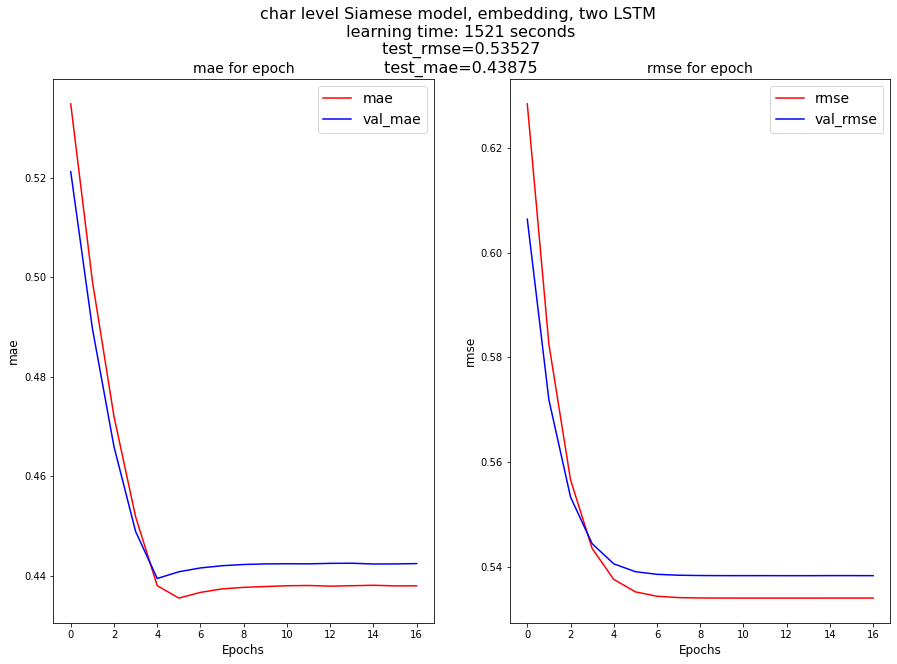

In [ ]:
evaluate_keras_model("char level Siamese model, embedding, two LSTM", history, learning_time, test_scores)

### Embedding + three LSTM layer

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

callbacks = [EarlyStopping(monitor='val_root_mean_squared_error', mode="min",
                           patience=3, restore_best_weights=True, verbose=1),
             ModelCheckpoint('models/char/embedding_3.h5',
                             monitor='val_root_mean_squared_error', mode="min",
                             verbose=1, save_best_only=True)]

model = siamese_lstm((CHAR_MAX_QUERY), (CHAR_MAX_DESC),
                     len(char_tokenizer.word_index)+1,
                     len(char_tokenizer.word_index)+1,
                     10, 10, True, 3)

start_learning_time = time.time()
history = model.fit(x=(train['search'], train['description']), y=train['labels'],
                    validation_data=((val['search'], val['description']), val['labels']),
                    batch_size=256, epochs=20, callbacks=callbacks,)
learning_time = time.time() - start_learning_time
learning_time

Epoch 1/20
232/232 [==============================] - 158s 627ms/step - loss: 0.2839 - root_mean_squared_error: 0.5328 - mae: 0.4368 - val_loss: 0.2854 - val_root_mean_squared_error: 0.5342 - val_mae: 0.4415

Epoch 00001: val_root_mean_squared_error improved from inf to 0.53423, saving model to models/char/embedding_3.h5
Epoch 2/20
232/232 [==============================] - 142s 612ms/step - loss: 0.2803 - root_mean_squared_error: 0.5295 - mae: 0.4342 - val_loss: 0.2795 - val_root_mean_squared_error: 0.5286 - val_mae: 0.4333

Epoch 00002: val_root_mean_squared_error improved from 0.53423 to 0.52865, saving model to models/char/embedding_3.h5
Epoch 3/20
232/232 [==============================] - 142s 613ms/step - loss: 0.2752 - root_mean_squared_error: 0.5246 - mae: 0.4305 - val_loss: 0.2793 - val_root_mean_squared_error: 0.5285 - val_mae: 0.4325

Epoch 00003: val_root_mean_squared_error improved from 0.52865 to 0.52846, saving model to models/char/embedding_3.h5
Epoch 4/20
232/232 [===

2870.357490539551

In [ ]:
test_scores = model.evaluate(x=(test['search'], test['description']), y=test['labels'], batch_size=512)
test_scores

219/219 [==============================] - 78s 357ms/step - loss: 0.2818 - root_mean_squared_error: 0.5308 - mae: 0.4359


[0.28176936507225037, 0.5307931900024414, 0.435941606760025]

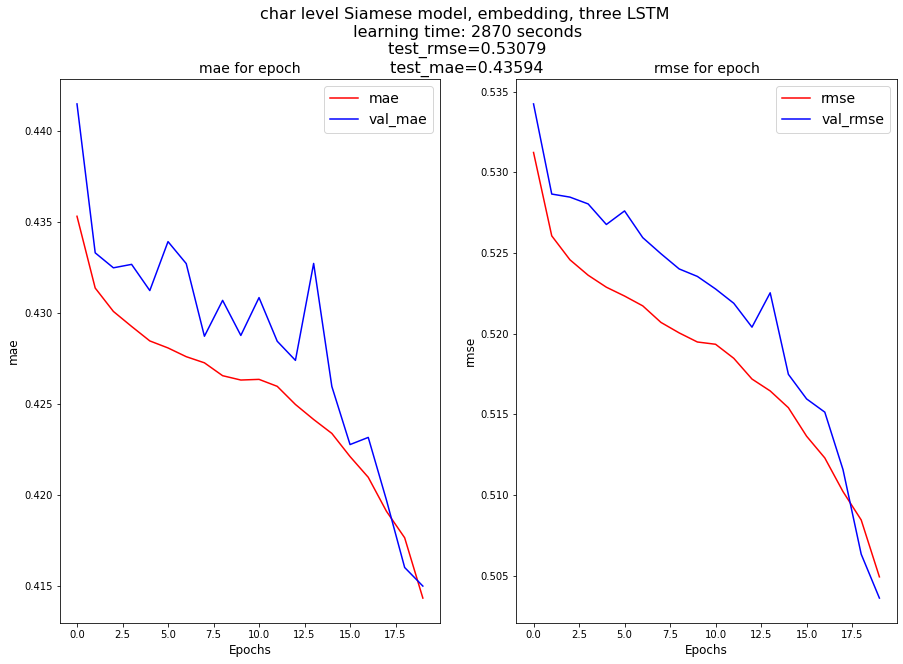

In [ ]:
evaluate_keras_model("char level Siamese model, embedding, three LSTM", history, learning_time, test_scores)

### No embedding + one LSTM layer

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

callbacks = [EarlyStopping(monitor='val_root_mean_squared_error', mode="min",
                           patience=3, restore_best_weights=True, verbose=1),
             ModelCheckpoint('models/char/no_embedding_1.h5',
                             monitor='val_root_mean_squared_error', mode="min",
                             verbose=1, save_best_only=True)]

model = siamese_lstm((CHAR_MAX_QUERY), (CHAR_MAX_DESC),
                     len(char_tokenizer.word_index)+1,
                     len(char_tokenizer.word_index)+1,
                     10, 10, False, 1)

start_learning_time = time.time()
history = model.fit(x=(train['search'], train['description']), y=train['labels'],
                    validation_data=((val['search'], val['description']), val['labels']),
                    batch_size=256, epochs=20, callbacks=callbacks,)
learning_time = time.time() - start_learning_time
learning_time

Epoch 1/20
232/232 [==============================] - 48s 188ms/step - loss: 0.2847 - root_mean_squared_error: 0.5336 - mae: 0.4377 - val_loss: 0.2834 - val_root_mean_squared_error: 0.5324 - val_mae: 0.4368

Epoch 00001: val_root_mean_squared_error improved from inf to 0.53240, saving model to models/char/no_embedding_1.h5
Epoch 2/20
232/232 [==============================] - 36s 155ms/step - loss: 0.2768 - root_mean_squared_error: 0.5261 - mae: 0.4319 - val_loss: 0.2835 - val_root_mean_squared_error: 0.5324 - val_mae: 0.4372

Epoch 00002: val_root_mean_squared_error did not improve from 0.53240
Epoch 3/20
232/232 [==============================] - 36s 156ms/step - loss: 0.2777 - root_mean_squared_error: 0.5270 - mae: 0.4322 - val_loss: 0.2818 - val_root_mean_squared_error: 0.5308 - val_mae: 0.4359

Epoch 00003: val_root_mean_squared_error improved from 0.53240 to 0.53083, saving model to models/char/no_embedding_1.h5
Epoch 4/20
232/232 [==============================] - 36s 156ms/step

758.0875189304352

In [ ]:
test_scores = model.evaluate(x=(test['search'], test['description']), y=test['labels'], batch_size=512)
test_scores

219/219 [==============================] - 20s 93ms/step - loss: 0.2824 - root_mean_squared_error: 0.5314 - mae: 0.4360


[0.28239521384239197, 0.5314087271690369, 0.4360159933567047]

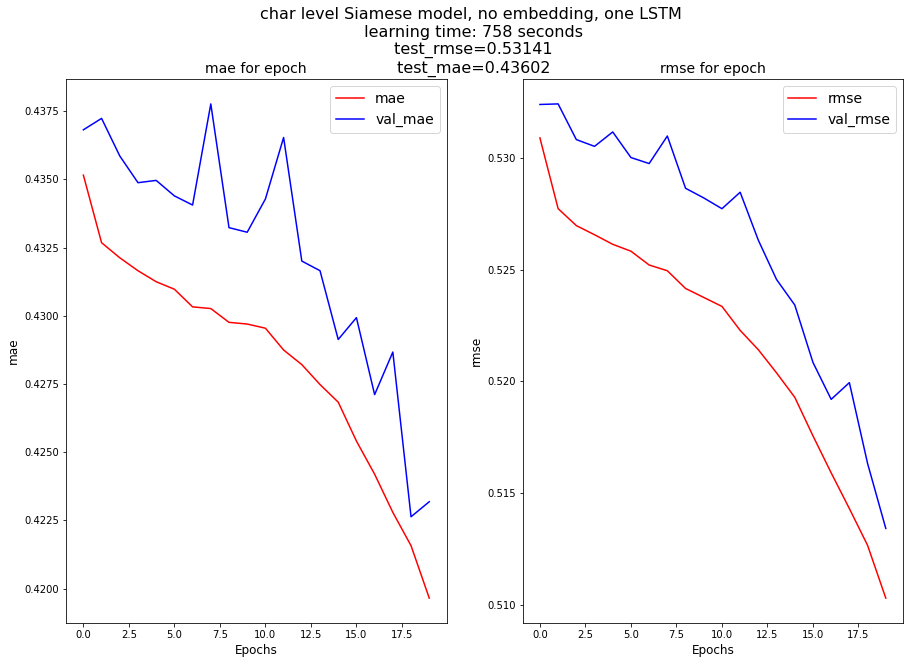

In [ ]:
evaluate_keras_model("char level Siamese model, no embedding, one LSTM", history, learning_time, test_scores)

### No embedding + two LSTM layer

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

callbacks = [EarlyStopping(monitor='val_root_mean_squared_error', mode="min",
                           patience=3, restore_best_weights=True, verbose=1),
             ModelCheckpoint('models/char/no_embedding_2.h5',
                             monitor='val_root_mean_squared_error', mode="min",
                             verbose=1, save_best_only=True)]

model = siamese_lstm((CHAR_MAX_QUERY), (CHAR_MAX_DESC),
                     len(char_tokenizer.word_index)+1,
                     len(char_tokenizer.word_index)+1,
                     10, 10, False, 2)

start_learning_time = time.time()
history = model.fit(x=(train['search'], train['description']), y=train['labels'],
                    validation_data=((val['search'], val['description']), val['labels']),
                    batch_size=256, epochs=20, callbacks=callbacks,)
learning_time = time.time() - start_learning_time
learning_time

Epoch 1/20
232/232 [==============================] - 103s 407ms/step - loss: 0.2827 - root_mean_squared_error: 0.5317 - mae: 0.4363 - val_loss: 0.2827 - val_root_mean_squared_error: 0.5317 - val_mae: 0.4356

Epoch 00001: val_root_mean_squared_error improved from inf to 0.53174, saving model to models/char/no_embedding_2.h5
Epoch 2/20
232/232 [==============================] - 90s 390ms/step - loss: 0.2802 - root_mean_squared_error: 0.5293 - mae: 0.4339 - val_loss: 0.2827 - val_root_mean_squared_error: 0.5317 - val_mae: 0.4365

Epoch 00002: val_root_mean_squared_error improved from 0.53174 to 0.53174, saving model to models/char/no_embedding_2.h5
Epoch 3/20
232/232 [==============================] - 88s 379ms/step - loss: 0.2771 - root_mean_squared_error: 0.5264 - mae: 0.4313 - val_loss: 0.2822 - val_root_mean_squared_error: 0.5312 - val_mae: 0.4372

Epoch 00003: val_root_mean_squared_error improved from 0.53174 to 0.53122, saving model to models/char/no_embedding_2.h5
Epoch 4/20
232/2

1796.7213680744171

In [ ]:
test_scores = model.evaluate(x=(test['search'], test['description']), y=test['labels'], batch_size=512)
test_scores

219/219 [==============================] - 49s 222ms/step - loss: 0.2829 - root_mean_squared_error: 0.5319 - mae: 0.4346


[0.28290146589279175, 0.5318848490715027, 0.43464308977127075]

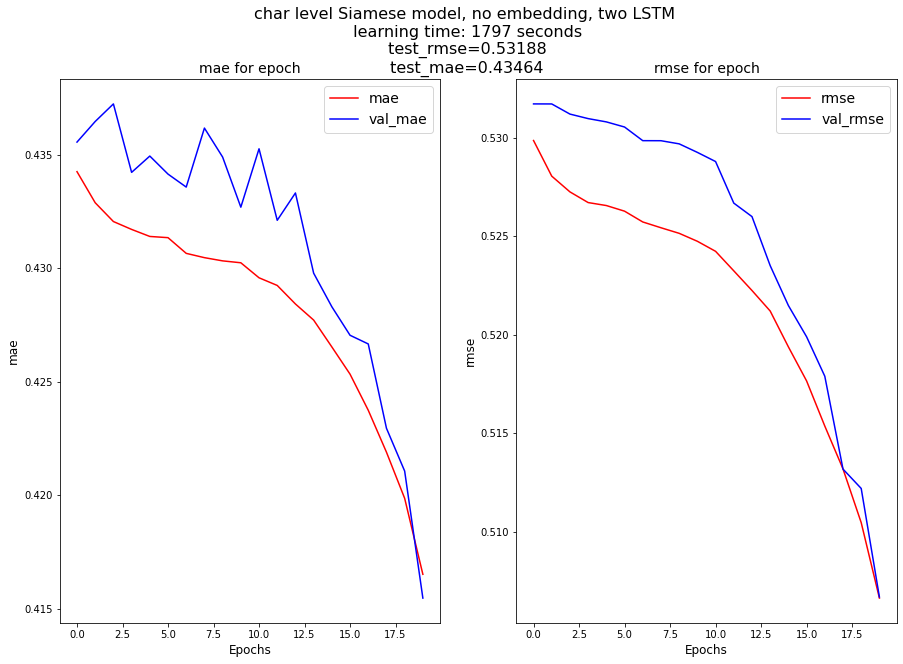

In [ ]:
evaluate_keras_model("char level Siamese model, no embedding, two LSTM", history, learning_time, test_scores)

### No embedding + three LSTM layer

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

callbacks = [EarlyStopping(monitor='val_root_mean_squared_error', mode="min",
                           patience=3, restore_best_weights=True, verbose=1),
             ModelCheckpoint('models/char/no_embedding_3.h5',
                             monitor='val_root_mean_squared_error', mode="min",
                             verbose=1, save_best_only=True)]

model = siamese_lstm((CHAR_MAX_QUERY), (CHAR_MAX_DESC),
                     len(char_tokenizer.word_index)+1,
                     len(char_tokenizer.word_index)+1,
                     10, 10, False, 3)

start_learning_time = time.time()
history = model.fit(x=(train['search'], train['description']), y=train['labels'],
                    validation_data=((val['search'], val['description']), val['labels']),
                    batch_size=256, epochs=20, callbacks=callbacks,)
learning_time = time.time() - start_learning_time
learning_time

Epoch 1/20
232/232 [==============================] - 155s 617ms/step - loss: 0.4164 - root_mean_squared_error: 0.6451 - mae: 0.5472 - val_loss: 0.3675 - val_root_mean_squared_error: 0.6062 - val_mae: 0.5211

Epoch 00001: val_root_mean_squared_error improved from inf to 0.60621, saving model to models/char/no_embedding_3.h5
Epoch 2/20
232/232 [==============================] - 142s 611ms/step - loss: 0.3492 - root_mean_squared_error: 0.5909 - mae: 0.5068 - val_loss: 0.3270 - val_root_mean_squared_error: 0.5718 - val_mae: 0.4897

Epoch 00002: val_root_mean_squared_error improved from 0.60621 to 0.57184, saving model to models/char/no_embedding_3.h5
Epoch 3/20
232/232 [==============================] - 157s 677ms/step - loss: 0.3164 - root_mean_squared_error: 0.5625 - mae: 0.4795 - val_loss: 0.3062 - val_root_mean_squared_error: 0.5534 - val_mae: 0.4660

Epoch 00003: val_root_mean_squared_error improved from 0.57184 to 0.55336, saving model to models/char/no_embedding_3.h5
Epoch 4/20
232

2846.2946124076843

In [ ]:
test_scores = model.evaluate(x=(test['search'], test['description']), y=test['labels'], batch_size=512)
test_scores

219/219 [==============================] - 75s 341ms/step - loss: 0.2865 - root_mean_squared_error: 0.5353 - mae: 0.4387


[0.2865181267261505, 0.5352739095687866, 0.438742458820343]

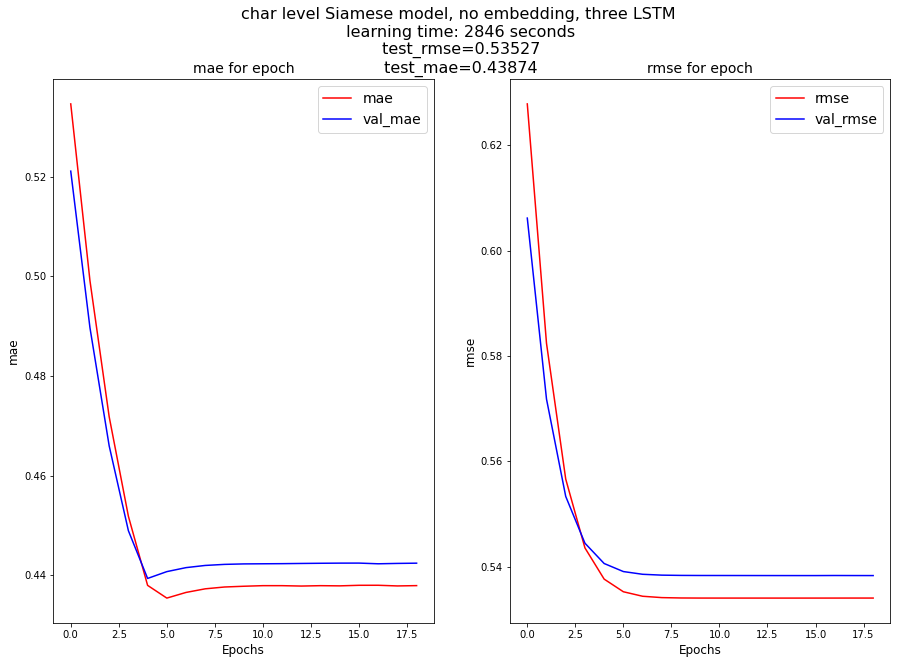

In [ ]:
evaluate_keras_model("char level Siamese model, no embedding, three LSTM", history, learning_time, test_scores)

## Naive Model - 1.c

In [ ]:
test_search = test_df['search_term'].to_numpy()
test_desc = test_df['product_description'].to_numpy()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
import time

corpus = np.concatenate([train_search, train_desc])
count_tokenaizer = CountVectorizer(analyzer='char_wb')
count_tokenaizer.fit(corpus)

naive_train_data = np.concatenate([count_tokenaizer.transform(train_search).toarray(),
                                   count_tokenaizer.transform(train_desc).toarray()], axis=1)
naive_train_labels = train_df['relevance'].to_numpy()

naive_val_data = np.concatenate([count_tokenaizer.transform(val_search).toarray(),
                                 count_tokenaizer.transform(val_desc).toarray()], axis=1)
naive_val_labels = val_df['relevance'].to_numpy()

naive_test_data = np.concatenate([count_tokenaizer.transform(test_search).toarray(),
                                  count_tokenaizer.transform(test_desc).toarray()], axis=1)
naive_test_labels = test_df['relevance'].to_numpy()


In [ ]:
runtime = time.time()
rf_reg = RandomForestRegressor(max_depth=50, n_jobs=-1, verbose=2)
rf_reg.fit(naive_train_data, naive_train_labels)
runtime = time.time() - runtime

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   49.3s


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


In [ ]:
evaluate_sklearn_model("naive char level random forest regressor", rf_reg,
                       (naive_train_data, naive_train_labels),
                       (naive_val_data, naive_val_labels),
                       (naive_test_data, naive_test_labels), runtime)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


model naive char level random forest regressor took 129.86631202697754 seconds to learn
evaluating train set...


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s


train rmse=0.1956853175862731  train mae=0.1557730595732416
evaluating validation set...


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


validation rmse=0.19723781607795593  validation mae=0.15723884526538384
evaluating test set...


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.7s


test rmse=0.523616201062711  test mae=0.4280306258163205


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.9s finished


## Feature Extractor - 1.d

### Building the feature extractor model

after running all the models above, we chose the model that uses embedding and one layer of LSTM since it produces the best results in the shortest time.

In [ ]:
model = keras.models.load_model('models/char/embedding_1.h5')

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
search_input (InputLayer)       [(None, 30)]         0                                            
__________________________________________________________________________________________________
description_input (InputLayer)  [(None, 1500)]       0                                            
__________________________________________________________________________________________________
search_embedding (Embedding)    (None, 30, 10)       690         search_input[0][0]               
__________________________________________________________________________________________________
description_embedding (Embeddin (None, 1500, 10)     690         description_input[0][0]          
____________________________________________________________________________________________

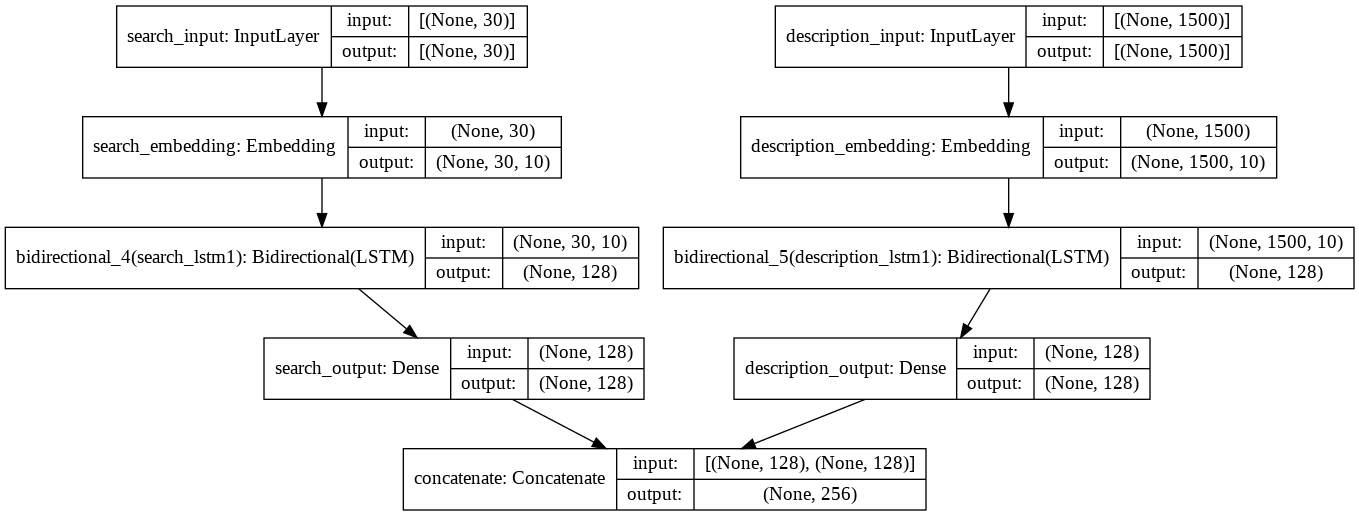

In [ ]:
search_out = model.get_layer("search_output").output
desc_out = model.get_layer("description_output").output
fe_out = layers.concatenate([search_out, desc_out], axis=1)
fe_model = keras.Model(inputs=model.inputs, outputs=fe_out)

print(fe_model.summary())
keras.utils.plot_model(fe_model, show_shapes=True)

### extracting features

In [ ]:
print("extracting features from train set....")
fe_train = fe_model.predict(x=(train['search'], train['description']), verbose=1)

print("extracting features from validation set....")
fe_val = fe_model.predict(x=(val['search'], val['description']), verbose=1)

print("extracting features from test set....")
fe_test = fe_model.predict(x=(test['search'], test['description']), verbose=1)

extracting features from train set....
1852/1852 [==============================] - 81s 43ms/step
extracting features from validation set....
371/371 [==============================] - 16s 43ms/step
extracting features from test set....
3503/3503 [==============================] - 153s 44ms/step


### models

In [ ]:
import time

#### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

lr_reg = LinearRegression(normalize=False, copy_X=True, n_jobs=-1)

start_learning_time = time.time()
lr_reg.fit(fe_train, train['labels'])
learning_time = time.time() - start_learning_time

In [ ]:
evaluate_sklearn_model("linear regression char level feature extracted", lr_reg,
                       (fe_train, train['labels']),
                       (fe_val, val['labels']),
                       (fe_test, test['labels']), learning_time)

model linear regression char level feature extracted took 0.6479077339172363 seconds to learn
evaluating train set...
train rmse=0.5145438253509909  train mae=0.42173527367364133
evaluating validation set...
validation rmse=0.5198172731308833  validation mae=0.4262435956404044
evaluating test set...
test rmse=0.5300855832663155  test mae=0.43372697400163


#### Linear SVM

In [ ]:
from sklearn.svm import LinearSVR

lsvm_reg = LinearSVR(C=0.1, loss='squared_epsilon_insensitive', max_iter=5000)

start_learning_time = time.time()
lsvm_reg.fit(fe_train, train['labels'])
learning_time = time.time() - start_learning_time

In [ ]:
evaluate_sklearn_model("linear svm regressor char level feature extracted", lsvm_reg,
                       (fe_train, train['labels']),
                       (fe_val, val['labels']),
                       (fe_test, test['labels']), learning_time)

model linear svm regressor char level feature extracted took 7.863869667053223 seconds to learn
evaluating train set...
train rmse=0.5148708536607165  train mae=0.42208017341462906
evaluating validation set...
validation rmse=0.5201546843742663  validation mae=0.42669711644953934
evaluating test set...
test rmse=0.5292729772330752  test mae=0.4331854738354458


#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=5, weights='distance',
                              algorithm='auto', leaf_size=30, p=2,
                              metric='minkowski', n_jobs=-1)

start_learning_time = time.time()
knn_reg.fit(fe_train, train['labels'])
learning_time = time.time() - start_learning_time

In [ ]:
evaluate_sklearn_model("knn regressor char level feature extracted", knn_reg,
                       (fe_train, train['labels']),
                       (fe_val, val['labels']),
                       (fe_test, test['labels']), learning_time)

model knn regressor char level feature extracted took 14.38676643371582 seconds to learn
evaluating train set...
train rmse=0.11244590856528992  train mae=0.03136103938478502
evaluating validation set...
validation rmse=0.11472790283208384  validation mae=0.03235951834012235
evaluating test set...
test rmse=0.5831612876285808  test mae=0.4667960077528978


# 2. Word Level

## Preprocessing - 2.a

In [ ]:
WORD_MAX_QUERY = 5   # out of 17
WORD_MAX_DESC = 500  # out of 1045

train_search = train_df['search_term'].to_numpy()
train_desc = train_df['product_description'].to_numpy()

val_search = val_df['search_term'].to_numpy()
val_desc = val_df['product_description'].to_numpy()

test_search = test_df['search_term'].to_numpy()
test_desc = test_df['product_description'].to_numpy()

word_tokenizer = text.Tokenizer()
word_tokenizer.fit_on_texts(np.concatenate([train_search, train_desc]))

train = process_data(train_df, word_tokenizer, WORD_MAX_QUERY, WORD_MAX_DESC)
val = process_data(val_df, word_tokenizer, WORD_MAX_QUERY, WORD_MAX_DESC)
test = process_data(test_df, word_tokenizer, WORD_MAX_QUERY, WORD_MAX_DESC)

## Siamese network - 2.b+2.c

### Embedding + one LSTM layer

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

callbacks = [EarlyStopping(monitor='val_root_mean_squared_error', mode="min",
                           patience=3, restore_best_weights=True, verbose=1),
             ModelCheckpoint('models/word/embedding_1.h5',
                             monitor='val_root_mean_squared_error', mode="min",
                             verbose=1, save_best_only=True)]

model = siamese_lstm((WORD_MAX_QUERY), (WORD_MAX_DESC),
                     len(word_tokenizer.word_index)+1,
                     len(word_tokenizer.word_index)+1,
                     100, 100, True, 1)

start_learning_time = time.time()
history = model.fit(x=(train['search'], train['description']), y=train['labels'],
                    validation_data=((val['search'], val['description']), val['labels']),
                    batch_size=256, epochs=20, callbacks=callbacks,)
learning_time = time.time() - start_learning_time
learning_time

Epoch 1/20
232/232 [==============================] - 63s 254ms/step - loss: 0.4351 - root_mean_squared_error: 0.6451 - mae: 0.5482 - val_loss: 0.3692 - val_root_mean_squared_error: 0.6057 - val_mae: 0.5207

Epoch 00001: val_root_mean_squared_error improved from inf to 0.60572, saving model to models/word/embedding_1.h5
Epoch 2/20
232/232 [==============================] - 56s 240ms/step - loss: 0.3519 - root_mean_squared_error: 0.5921 - mae: 0.5084 - val_loss: 0.3264 - val_root_mean_squared_error: 0.5711 - val_mae: 0.4890

Epoch 00002: val_root_mean_squared_error improved from 0.60572 to 0.57112, saving model to models/word/embedding_1.h5
Epoch 3/20
232/232 [==============================] - 58s 249ms/step - loss: 0.3127 - root_mean_squared_error: 0.5590 - mae: 0.4756 - val_loss: 0.3048 - val_root_mean_squared_error: 0.5519 - val_mae: 0.4646

Epoch 00003: val_root_mean_squared_error improved from 0.57112 to 0.55190, saving model to models/word/embedding_1.h5
Epoch 4/20
232/232 [======

1160.4940021038055

In [ ]:
test_scores = model.evaluate(x=(test['search'], test['description']), y=test['labels'], batch_size=512)
test_scores

219/219 [==============================] - 25s 112ms/step - loss: 0.3439 - root_mean_squared_error: 0.5804 - mae: 0.4601


[0.3438894748687744, 0.5804423689842224, 0.4601392149925232]

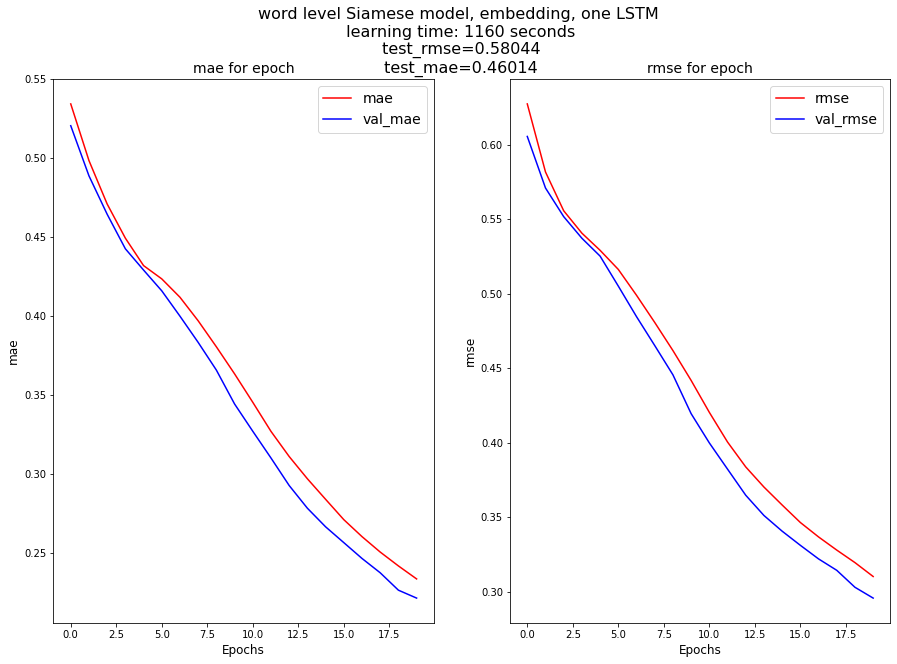

In [ ]:
evaluate_keras_model("word level Siamese model, embedding, one LSTM", history, learning_time, test_scores)

### Embedding + two LSTM layer

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

callbacks = [EarlyStopping(monitor='val_root_mean_squared_error', mode="min",
                           patience=3, restore_best_weights=True, verbose=1),
             ModelCheckpoint('models/word/embedding_2.h5',
                             monitor='val_root_mean_squared_error', mode="min",
                             verbose=1, save_best_only=True)]

model = siamese_lstm((WORD_MAX_QUERY), (WORD_MAX_DESC),
                     len(word_tokenizer.word_index)+1,
                     len(word_tokenizer.word_index)+1,
                     100, 100, True, 2)

start_learning_time = time.time()
history = model.fit(x=(train['search'], train['description']), y=train['labels'],
                    validation_data=((val['search'], val['description']), val['labels']),
                    batch_size=256, epochs=20, callbacks=callbacks,)
learning_time = time.time() - start_learning_time
learning_time

Epoch 1/20
232/232 [==============================] - 90s 350ms/step - loss: 0.4319 - root_mean_squared_error: 0.6426 - mae: 0.5451 - val_loss: 0.3692 - val_root_mean_squared_error: 0.6057 - val_mae: 0.5207

Epoch 00001: val_root_mean_squared_error improved from inf to 0.60573, saving model to models/word/embedding_2.h5
Epoch 2/20
232/232 [==============================] - 76s 327ms/step - loss: 0.3490 - root_mean_squared_error: 0.5897 - mae: 0.5055 - val_loss: 0.3268 - val_root_mean_squared_error: 0.5715 - val_mae: 0.4893

Epoch 00002: val_root_mean_squared_error improved from 0.60573 to 0.57147, saving model to models/word/embedding_2.h5
Epoch 3/20
232/232 [==============================] - 79s 340ms/step - loss: 0.3151 - root_mean_squared_error: 0.5612 - mae: 0.4776 - val_loss: 0.3061 - val_root_mean_squared_error: 0.5532 - val_mae: 0.4657

Epoch 00003: val_root_mean_squared_error improved from 0.57147 to 0.55318, saving model to models/word/embedding_2.h5
Epoch 4/20
232/232 [======

1338.7932291030884

In [ ]:
test_scores = model.evaluate(x=(test['search'], test['description']), y=test['labels'], batch_size=512)
test_scores

219/219 [==============================] - 35s 160ms/step - loss: 0.2865 - root_mean_squared_error: 0.5353 - mae: 0.4388


[0.2865246832370758, 0.5352755784988403, 0.438774049282074]

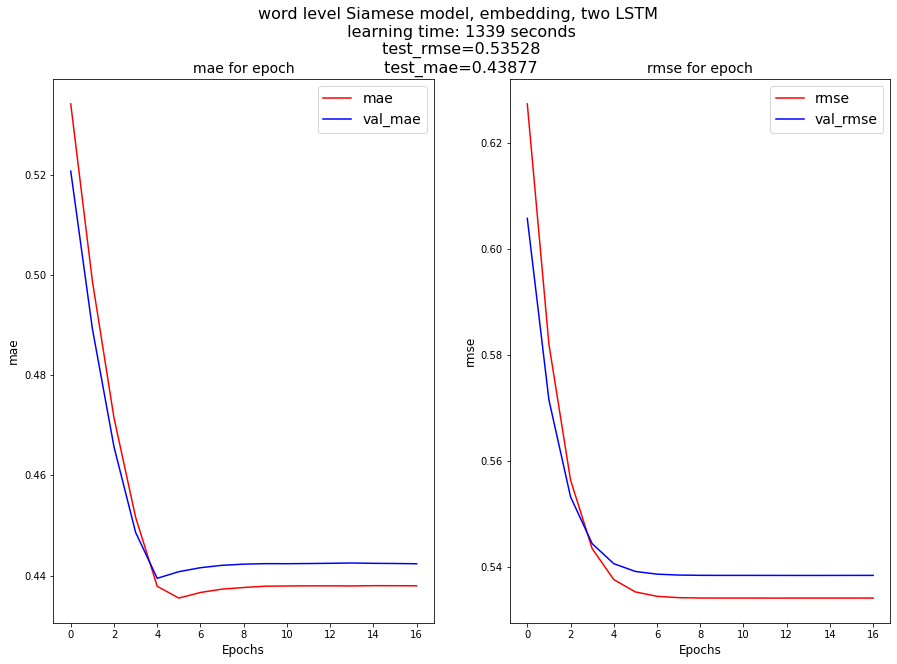

In [ ]:
evaluate_keras_model("word level Siamese model, embedding, two LSTM", history, learning_time, test_scores)

## Feature Extractor - 2.d

### Building the feature extractor model

after running all the models above, we chose the model that uses embedding and one layer of LSTM since it produces the best results in the shortest time.

In [ ]:
model = keras.models.load_model('models/word/embedding_1.h5')

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
search_input (InputLayer)       [(None, 5)]          0                                            
__________________________________________________________________________________________________
description_input (InputLayer)  [(None, 500)]        0                                            
__________________________________________________________________________________________________
search_embedding (Embedding)    (None, 5, 100)       15560300    search_input[0][0]               
__________________________________________________________________________________________________
description_embedding (Embeddin (None, 500, 100)     15560300    description_input[0][0]          
___________________________________________________________________________________________

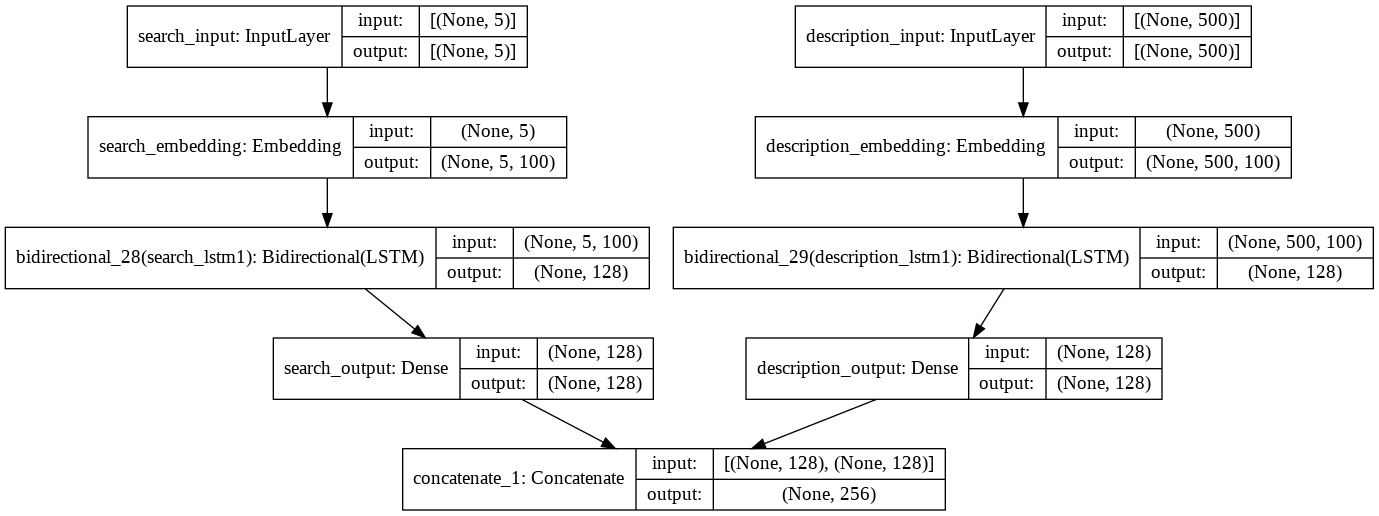

In [ ]:
search_out = model.get_layer("search_output").output
desc_out = model.get_layer("description_output").output
fe_out = layers.concatenate([search_out, desc_out], axis=1)
fe_model = keras.Model(inputs=model.inputs, outputs=fe_out)

print(fe_model.summary())
keras.utils.plot_model(fe_model, show_shapes=True)

### extracting features

In [ ]:
print("extracting features from train set....")
fe_train = fe_model.predict(x=(train['search'], train['description']), verbose=1)

print("extracting features from validation set....")
fe_val = fe_model.predict(x=(val['search'], val['description']), verbose=1)

print("extracting features from test set....")
fe_test = fe_model.predict(x=(test['search'], test['description']), verbose=1)

extracting features from train set....
1852/1852 [==============================] - 34s 18ms/step
extracting features from validation set....
371/371 [==============================] - 7s 18ms/step
extracting features from test set....
3503/3503 [==============================] - 62s 18ms/step


### models

In [ ]:
import time

#### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

lr_reg = LinearRegression(normalize=False, copy_X=True, n_jobs=-1)

start_learning_time = time.time()
lr_reg.fit(fe_train, train['labels'])
learning_time = time.time() - start_learning_time

In [ ]:
evaluate_sklearn_model("linear regression word level feature extracted", lr_reg,
                       (fe_train, train['labels']),
                       (fe_val, val['labels']),
                       (fe_test, test['labels']), learning_time)

model linear regression word level feature extracted took 0.7449712753295898 seconds to learn
evaluating train set...
train rmse=0.432968195078084  train mae=0.34634663551766676
evaluating validation set...
validation rmse=0.437856917451108  validation mae=0.3499846155502034
evaluating test set...
test rmse=0.5529872286195289  test mae=0.4412935019129161


#### Linear SVM

In [ ]:
from sklearn.svm import LinearSVR

lsvm_reg = LinearSVR(C=0.1, loss='squared_epsilon_insensitive', max_iter=5000)

start_learning_time = time.time()
lsvm_reg.fit(fe_train, train['labels'])
learning_time = time.time() - start_learning_time

In [ ]:
evaluate_sklearn_model("linear svm regressor word level feature extracted", lsvm_reg,
                       (fe_train, train['labels']),
                       (fe_val, val['labels']),
                       (fe_test, test['labels']), learning_time)

model linear svm regressor word level feature extracted took 0.4569723606109619 seconds to learn
evaluating train set...
train rmse=0.4356919725333101  train mae=0.34885110369303574
evaluating validation set...
validation rmse=0.44090362035545777  validation mae=0.35290684478063233
evaluating test set...
test rmse=0.5509689483250989  test mae=0.44029340645691756


#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=5, weights='distance',
                              algorithm='auto', leaf_size=30, p=2,
                              metric='minkowski', n_jobs=-1)

start_learning_time = time.time()
knn_reg.fit(fe_train, train['labels'])
learning_time = time.time() - start_learning_time

In [ ]:
evaluate_sklearn_model("knn regressor word level feature extracted", knn_reg,
                       (fe_train, train['labels']),
                       (fe_val, val['labels']),
                       (fe_test, test['labels']), learning_time)

model knn regressor word level feature extracted took 11.026409387588501 seconds to learn
evaluating train set...
train rmse=0.07162921275462727  train mae=0.012789996568387535
evaluating validation set...
validation rmse=0.07308245364025999  validation mae=0.013173670943793465
evaluating test set...
test rmse=0.6150171694019645  test mae=0.4790474453260743


# 3. Models comparison

In [ ]:
comparison

,Model type,runtime,Train RMSE,Val RMSE,Test RMSE,Train MAE,Val MAE,Test MAE
0,"char level Siamese model, embedding, one LSTM",797.012830,0.514336,0.518278,0.528201,0.423861,0.427505,0.434467
1,"char level Siamese model, embedding, two LSTM",1521.135310,0.534052,0.538327,0.535274,0.437967,0.442484,0.438749
2,"char level Siamese model, embedding, three LSTM",2870.357491,0.504926,0.503611,0.530793,0.414314,0.414975,0.435942
3,"char level Siamese model, no embedding, one LSTM",758.087519,0.510297,0.513416,0.531409,0.419651,0.423184,0.436016
4,"char level Siamese model, no embedding, two LSTM",1796.721368,0.506615,0.506671,0.531885,0.416509,0.415460,0.434643
5,"char level Siamese model, no embedding, three ...",2846.294612,0.534054,0.538327,0.535274,0.438025,0.442477,0.438742
6,naive char level random forest regressor,129.866312,0.195685,0.197238,0.523616,0.155773,0.157239,0.428031
7,linear regression char level feature extracted,0.647908,0.514544,0.519817,0.530086,0.421735,0.426244,0.433727
8,linear svm regressor char level feature extracted,7.863870,0.514871,0.520155,0.529273,0.422080,0.426697,0.433185
9,knn regressor char level feature extracted,14.386766,0.112446,0.114728,0.583161,0.031361,0.032360,0.466796


# Conclusion

From the table above, we can see that our models reach relatively good results with RMSE 0.52 at best (on the test set). We can also see that the range of results is not very large, with almost all the test RMSE's in the 0.52-0.55 range. It seems that the word-level models performed worse using these tokenization methods. This is likely because we used custom word embeddings and the lack of data and optimization for these embeddings.

Additionally, the difference between the neural network models and the classical ML models is very little, indicating that there is probably room for improvement for the neural network models or that our tokenization method is too generic and might be optimized for the data and models.

Finally, we could optimize the features themselves better for the problem by adding features like the product title. We could also change the problem space from regression to classification, seeing as there are only 13 unique similarity values representing discrete levels of similarity.